In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
project_path = '/content/drive/MyDrive/BLG454EProject'
os.chdir(project_path)

!ls

cifar10_train_eval.ipynb  fashion_train_eval.ipynb
distiller		  mnist_train_eval.ipynb


This notebook compares how well a simple **LeNet** model performs when trained on:
1. The **full** Fashion MNIST training set (60 k images)
2. A **randomly‑sampled** subset containing **10 images per class** (100 images total)
3. A **distilled** synthetic set generated with Gradient Matching

We evaluate each model on the **canonical Fashion MNIST test split (10 k images)** and summarise the results.


In [3]:
import os, random, math, time, copy
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from distiller.models.LeNet import LeNet

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cuda


In [4]:
def train(model, loader, criterion, optimizer, epochs=5, log_interval=100):
    model.train()
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(loader, 1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % log_interval == 0 or batch_idx == len(loader):
                print(f'Epoch {epoch}/{epochs} | Batch {batch_idx}/{len(loader)} | Loss: {running_loss / batch_idx:.4f}', end='\r')
        print(f'Epoch {epoch} finished. Avg Loss: {running_loss / len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return 100.0 * correct / total


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

root = Path('distiller/data')
full_train = datasets.FashionMNIST(root, train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root, train=False, download=True, transform=transform)

test_loader = DataLoader(test_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

print(f'Full training set size: {len(full_train)}')

Full training set size: 60000


## Training on the full Fashion MNIST training set

In [6]:
BATCH_SIZE_FULL = 128
EPOCHS_FULL = 5

full_loader = DataLoader(full_train, batch_size=BATCH_SIZE_FULL, shuffle=True, num_workers=2, pin_memory=True)

model_full = LeNet().to(device)
optimizer = optim.Adam(model_full.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train(model_full, full_loader, criterion, optimizer, epochs=EPOCHS_FULL, log_interval=200)
acc_full = evaluate(model_full, test_loader)
print(f'\nTest accuracy (full data): {acc_full:.2f}%')

Epoch 1 finished. Avg Loss: 0.6372
Epoch 2 finished. Avg Loss: 0.3984
Epoch 3 finished. Avg Loss: 0.3346
Epoch 4 finished. Avg Loss: 0.3016
Epoch 5 finished. Avg Loss: 0.2808

Test accuracy (full data): 88.74%


## Training on a random subset (10 images × 10 classes = 100 images)

In [7]:
def stratified_random_subset(dataset, per_class=10):
    targets = np.array(dataset.targets)
    indices = []
    for cls in range(10):
        cls_idx = np.where(targets == cls)[0]
        indices.extend(np.random.choice(cls_idx, per_class, replace=False))
    return indices

subset_indices = stratified_random_subset(full_train, per_class=10)
small_train = Subset(full_train, subset_indices)
print('Subset size:', len(small_train))

BATCH_SIZE_SMALL = 32
EPOCHS_SMALL = 50  # More epochs because dataset is tiny

small_loader = DataLoader(small_train, batch_size=BATCH_SIZE_SMALL, shuffle=True, num_workers=2, pin_memory=True)

model_small = LeNet().to(device)
optimizer_small = optim.Adam(model_small.parameters(), lr=1e-3)
criterion_small = nn.CrossEntropyLoss()

train(model_small, small_loader, criterion_small, optimizer_small, epochs=EPOCHS_SMALL, log_interval=1)
acc_small = evaluate(model_small, test_loader)
print(f'\nTest accuracy (random 100 examples): {acc_small:.2f}%')

Subset size: 100
Epoch 1 finished. Avg Loss: 2.2984
Epoch 2 finished. Avg Loss: 2.2607
Epoch 3 finished. Avg Loss: 2.2253
Epoch 4 finished. Avg Loss: 2.1216
Epoch 5 finished. Avg Loss: 2.0245
Epoch 6 finished. Avg Loss: 1.8332
Epoch 7 finished. Avg Loss: 1.6440
Epoch 8 finished. Avg Loss: 1.4840
Epoch 9 finished. Avg Loss: 1.2459
Epoch 10 finished. Avg Loss: 1.1814
Epoch 11 finished. Avg Loss: 1.0813
Epoch 12 finished. Avg Loss: 0.9843
Epoch 13 finished. Avg Loss: 0.7870
Epoch 14 finished. Avg Loss: 0.8350
Epoch 15 finished. Avg Loss: 0.8665
Epoch 16 finished. Avg Loss: 0.8959
Epoch 17 finished. Avg Loss: 0.9116
Epoch 18 finished. Avg Loss: 0.7670
Epoch 19 finished. Avg Loss: 0.6979
Epoch 20 finished. Avg Loss: 0.5529
Epoch 21 finished. Avg Loss: 0.5699
Epoch 22 finished. Avg Loss: 0.5795
Epoch 23 finished. Avg Loss: 0.4902
Epoch 24 finished. Avg Loss: 0.3952
Epoch 25 finished. Avg Loss: 0.4447
Epoch 26 finished. Avg Loss: 0.4610
Epoch 27 finished. Avg Loss: 0.3665
Epoch 28 finished. A

## Training on the distilled synthetic set

In [9]:
SYNSET_PATH = 'distiller/syndata/FASHIONMNIST_LeNet_ipc-10_exp-0.pt'

assert Path(SYNSET_PATH).exists(), (
    f'Distilled file not found at {SYNSET_PATH}. ' \
    'Upload it to the Colab session or place it in the working directory.'
)

checkpoint = torch.load(SYNSET_PATH, map_location='cpu')

# Expected keys: images (n, 1, 28, 28) tensor, labels (n) tensor
synthetic_images = checkpoint.get('syn_imgs') if isinstance(checkpoint, dict) else checkpoint[0]
synthetic_labels = checkpoint.get('syn_labels') if isinstance(checkpoint, dict) else checkpoint[1]

print('Synthetic set shape:', synthetic_images.shape)

distill_ds = TensorDataset(synthetic_images, synthetic_labels)
BATCH_SIZE_DISTILL = 32
EPOCHS_DISTILL = 300

distill_loader = DataLoader(distill_ds, batch_size=BATCH_SIZE_DISTILL, shuffle=True)

model_distill = LeNet().to(device)
optimizer_distill = optim.Adam(model_distill.parameters(), lr=1e-3)
criterion_distill = nn.CrossEntropyLoss()

train(model_distill, distill_loader, criterion_distill, optimizer_distill, epochs=EPOCHS_DISTILL, log_interval=1)
acc_distill = evaluate(model_distill, test_loader)
print(f'\nTest accuracy (distilled set): {acc_distill:.2f}%')

Synthetic set shape: torch.Size([100, 1, 28, 28])
Epoch 1 finished. Avg Loss: 2.2983
Epoch 2 finished. Avg Loss: 2.2628
Epoch 3 finished. Avg Loss: 2.1912
Epoch 4 finished. Avg Loss: 2.0622
Epoch 5 finished. Avg Loss: 1.8559
Epoch 6 finished. Avg Loss: 1.5760
Epoch 7 finished. Avg Loss: 1.2071
Epoch 8 finished. Avg Loss: 1.1444
Epoch 9 finished. Avg Loss: 0.7805
Epoch 10 finished. Avg Loss: 0.7525
Epoch 11 finished. Avg Loss: 0.7585
Epoch 12 finished. Avg Loss: 0.7685
Epoch 13 finished. Avg Loss: 0.5728
Epoch 14 finished. Avg Loss: 0.6286
Epoch 15 finished. Avg Loss: 0.5138
Epoch 16 finished. Avg Loss: 0.7990
Epoch 17 finished. Avg Loss: 0.5195
Epoch 18 finished. Avg Loss: 0.4956
Epoch 19 finished. Avg Loss: 0.4360
Epoch 20 finished. Avg Loss: 0.3941
Epoch 21 finished. Avg Loss: 0.4816
Epoch 22 finished. Avg Loss: 0.3507
Epoch 23 finished. Avg Loss: 0.3801
Epoch 24 finished. Avg Loss: 0.3393
Epoch 25 finished. Avg Loss: 0.3746
Epoch 26 finished. Avg Loss: 0.5126
Epoch 27 finished. Avg 

## Result Summary

Full Data   : 88.74%
Random 100  : 66.16%
Distilled Set: 57.77%


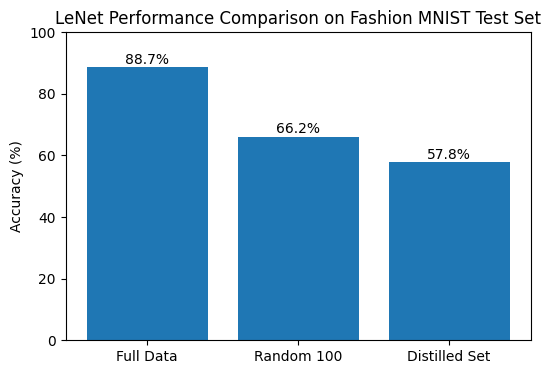

In [10]:
results = {
    'Full Data': acc_full,
    'Random 100': acc_small,
    'Distilled Set': acc_distill,
}

for k, v in results.items():
    print(f'{k:<12}: {v:5.2f}%')

# Bar chart
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values())
plt.ylabel('Accuracy (%)')
plt.title('LeNet Performance Comparison on Fashion MNIST Test Set')
plt.ylim(0, 100)
for i, v in enumerate(results.values()):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()
